In [1]:
import sys
sys.path.append('lib/')
print(sys.path)

['', '/home/mbajaj01/anaconda3/envs/py27/lib/python27.zip', '/home/mbajaj01/anaconda3/envs/py27/lib/python2.7', '/home/mbajaj01/anaconda3/envs/py27/lib/python2.7/plat-linux2', '/home/mbajaj01/anaconda3/envs/py27/lib/python2.7/lib-tk', '/home/mbajaj01/anaconda3/envs/py27/lib/python2.7/lib-old', '/home/mbajaj01/anaconda3/envs/py27/lib/python2.7/lib-dynload', '/home/mbajaj01/git_cv/py27/pytorch/build', '/home/mbajaj01/.local/lib/python2.7/site-packages', '/home/mbajaj01/git_cv/detectron', '/home/mbajaj01/anaconda3/envs/py27/lib/python2.7/site-packages', '/home/mbajaj01/anaconda3/envs/py27/lib/python2.7/site-packages/pycocotools-2.0-py2.7-linux-x86_64.egg', '/home/mbajaj01/anaconda3/envs/py27/lib/python2.7/site-packages', '/home/mbajaj01/anaconda3/envs/py27/lib/python2.7/site-packages/IPython/extensions', '/home/mbajaj01/.ipython', 'lib/']


In [18]:
# from core.test import *
# #import core.test.im_detect_bbox_aug as im_detect_bbox_aug




# def im_detect_all(model, im, box_proposals, timers=None):
#     if timers is None:
#         timers = defaultdict(Timer)

#     # Handle RetinaNet testing separately for now
#     if cfg.RETINANET.RETINANET_ON:
#         cls_boxes = test_retinanet.im_detect_bbox(model, im, timers)
#         return cls_boxes, None, None

#     timers['im_detect_bbox'].tic()
#     if cfg.TEST.BBOX_AUG.ENABLED:
#         scores, boxes, im_scale = im_detect_bbox_aug(model, im, box_proposals)
#     else:
#         scores, boxes, im_scale = im_detect_bbox(
#             model, im, cfg.TEST.SCALE, cfg.TEST.MAX_SIZE, boxes=box_proposals
#         )
#     timers['im_detect_bbox'].toc()
#     #return scores, boxes, im_scale

#     # score and boxes are from the whole image after score thresholding and nms
#     # (they are not separated by class)
#     # cls_boxes boxes and scores are separated by class and in the format used
#     # for evaluating results
#     timers['misc_bbox'].tic()
#     scores, boxes, cls_boxes = box_results_with_nms_and_limit(scores, boxes)
#     timers['misc_bbox'].toc()

#     if cfg.MODEL.MASK_ON and boxes.shape[0] > 0:
#         timers['im_detect_mask'].tic()
#         if cfg.TEST.MASK_AUG.ENABLED:
#             masks = im_detect_mask_aug(model, im, boxes)
#         else:
#             masks = im_detect_mask(model, im_scale, boxes)
#         timers['im_detect_mask'].toc()

#         timers['misc_mask'].tic()
#         cls_segms = segm_results(
#             cls_boxes, masks, boxes, im.shape[0], im.shape[1]
#         )
#         timers['misc_mask'].toc()
#     else:
#         cls_segms = None

#     if cfg.MODEL.KEYPOINTS_ON and boxes.shape[0] > 0:
#         timers['im_detect_keypoints'].tic()
#         if cfg.TEST.KPS_AUG.ENABLED:
#             heatmaps = im_detect_keypoints_aug(model, im, boxes)
#         else:
#             heatmaps = im_detect_keypoints(model, im_scale, boxes)
#         timers['im_detect_keypoints'].toc()

#         timers['misc_keypoints'].tic()
#         cls_keyps = keypoint_results(cls_boxes, heatmaps, boxes)
#         timers['misc_keypoints'].toc()
#     else:
#         cls_keyps = None

#     return cls_boxes, cls_segms, cls_keyps

In [2]:
import sys
sys.stdout = open("./log_txt", "w")
#print ("test sys.stdout")

In [ ]:
#!/usr/bin/env python2

# Copyright (c) 2017-present, Facebook, Inc.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
##############################################################################

"""Perform inference on a single image or all images with a certain extension
(e.g., .jpg) in a folder.
"""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

from collections import defaultdict
import argparse
import cv2  # NOQA (Must import before importing caffe2 due to bug in cv2)
import glob
import logging
import os
import sys
sys.path.append('lib/')
import time
import pickle
from caffe2.python import workspace

from core.config import assert_and_infer_cfg
from core.config import cfg
from core.config import merge_cfg_from_file
from utils.io import cache_url
from utils.timer import Timer
import core.test_engine as infer_engine
import datasets.dummy_datasets as dummy_datasets
import utils.c2 as c2_utils
import utils.logging
import utils.vis as vis_utils

c2_utils.import_detectron_ops()
# OpenCL may be enabled by default in OpenCV3; disable it because it's not
# thread safe and causes unwanted GPU memory allocations.
cv2.ocl.setUseOpenCL(False)


def parse_args():
    parser = argparse.ArgumentParser(description='End-to-end inference')
    parser.add_argument(
        '--cfg',
        dest='cfg',
        help='cfg model file (/path/to/model_config.yaml)',
        #default='configs/bbox2mask_vg/eval_sw_R101/runtest_clsbox_2_layer_mlp_nograd_R101.yaml',
        default='configs/bbox2mask_vg/eval_sw/runtest_clsbox_2_layer_mlp_nograd.yaml',
        type=str
    )
    parser.add_argument(
        '--wts',
        dest='weights',
        help='weights model file (/path/to/model_weights.pkl)',
        default='lib/datasets/data/trained_models/33241332_model_final_coco2vg3k_seg.pkl',
        #default='lib/datasets/data/trained_models/33219850_model_final_coco2vg3k_seg.pkl',
        type=str
    )
    parser.add_argument(
        '--output-dir',
        dest='output_dir',
        help='directory for visualization pdfs (default: /tmp/infer_simple)',
        default='bboxes_100_res50',
        type=str
    )
    parser.add_argument(
        '--image-ext',
        dest='image_ext',
        help='image file name extension (default: jpg)',
        default='jpg',
        type=str
    )
    parser.add_argument(
        '--im_or_folder',
        dest='im_or_folder',
        help='image or folder of images',
        default='jpg_videos/',
        #default='demo_vg3k/',
        type=str
    )
    parser.add_argument(
        '--use-vg3k',
        dest='use_vg3k',
        default=True,
        help='use Visual Genome 3k classes (instead of COCO 80 classes)',
        action='store_true'
    )
    parser.add_argument(
        '--thresh',
        default=0.3,
        #default=0.7,
        type=float,
        help='score threshold for predictions',
    )
#     if len(sys.argv) == 1:
#         parser.print_help()
#         sys.exit(1)
    import sys
    sys.argv=['']
    #del sys
    return parser.parse_args()



if __name__ == '__main__':
    
    workspace.GlobalInit(['caffe2', '--caffe2_log_level=0'])
    utils.logging.setup_logging(__name__)
    args = parse_args()
    #main(args)
    logger = logging.getLogger(__name__)
    first_try = True
    if first_try:
        merge_cfg_from_file(args.cfg)
        cfg.NUM_GPUS = 1
        args.weights = cache_url(args.weights, cfg.DOWNLOAD_CACHE)
        assert_and_infer_cfg(cache_urls=False)
        model = infer_engine.initialize_model_from_cfg(args.weights)
        #print(model)
        #return
        dummy_coco_dataset = (
            dummy_datasets.get_vg3k_dataset()
            if args.use_vg3k else dummy_datasets.get_coco_dataset())
    
    seg_vids = []
    pickle_path = "./seg_vids.p"
    count = 0
    processed_count = 0
    average_time = 0.
    if(os.path.exists(pickle_path)):   
        seg_vids = pickle.load( open( pickle_path , "rb" ) )
        processed_count = len(seg_vids)
        print("\n**************************************************\n")
        print("\n***********Already processed videos: ", len(seg_vids))
        print("\n**************************************************\n")
    
    dirs = os.listdir(args.im_or_folder)
    for dir_name in dirs:
        vid_timers = defaultdict(Timer)
        vid_timers['video_bbox'].tic()
        print(dir_name)
        if dir_name in seg_vids:
            continue
        video_path = os.path.join(args.im_or_folder, dir_name)
        images = os.listdir(video_path)    
        im_dict = {}
    

    
#     if os.path.isdir(args.im_or_folder):
#         im_list = glob.iglob(args.im_or_folder + '/*.' + args.image_ext)
#     else:
#         im_list = [args.im_or_folder]

        out_name = os.path.join(
                args.output_dir, '{}'.format(os.path.basename(dir_name) + '.p')
            )
        logger.info('Processing {} -> {}'.format(dir_name, out_name))


        for i, image in enumerate(images):
            im_name, ext = os.path.splitext(image)
            
            print(image)
            im_path = os.path.join(video_path, image)
            im = cv2.imread(im_path)
            timers = defaultdict(Timer)
            t = time.time()
            with c2_utils.NamedCudaScope(0):
    #             cls_boxes, cls_segms, cls_keyps = im_detect_all(
    #                 model, im, None, timers=timers)
#                 scores, boxes, im_scales, fc7_feats, roi_feats, im_info = im_detect_all(
#                     model, im, None, timers=timers)
        
                ans_scores, ans_boxes, cls_boxes, im_scales, fc7_feats, im_info = im_detect_all(model, im, None, timers=timers)


    #             cls_boxes, cls_segms, cls_keyps = infer_engine.im_detect_all(
    #                 model, im, None, timers=timers)
            logger.info('Inference time: {:.3f}s'.format(time.time() - t))
            for k, v in timers.items():
                logger.info(' | {}: {:.3f}s'.format(k, v.average_time))
            if i == 0:
                logger.info(
                    ' \ Note: inference on the first image will be slower than the '
                    'rest (caches and auto-tuning need to warm up)'
                )
                
#             im_dict[im_name] = {"raw_scores":raw_scores, "raw_boxes":raw_boxes, "cls_boxes":cls_boxes, 
#                                 "im_scales": im_scales, "fc7_feats": fc7_feats, "im_info":im_info}
            print(raw_boxes.shape, fc7_feats.shape, im_info.shape)
#             im_int = int(im_name[6:])
#             dim_2 = fc7_feats.shape[0]
#             im_array[im_int-1,:dim_2,:] = fc7_feats
            im_dict[im_name] = {"scores":ans_scores, "boxes":ans_boxes, "cls_boxes":cls_boxes,
                                "im_scales": im_scales, "fc7_feats": fc7_feats, "im_info":im_info}


        pickle.dump( im_dict, open( out_name, "wb" ) ) 
        seg_vids.append(dir_name)
        pickle.dump( seg_vids, open( pickle_path, "wb" ) ) 
        count +=1
        processed_count += 1
        print("\n**************************************************\n")
        print("Done: ", dir_name)
        print("Processed in this batch: ", count)
        print("Processed in total: ", processed_count)
        print("\n**************************************************\n")
        vid_timers['video_bbox'].toc()
        k='video_bbox'
        v=vid_timers[k]
        logger.info(' | {}: {:.3f}s'.format(k, v.average_time))
        average_time += v.average_time
        print("Average time per video: ",(average_time/count))



#         vis_utils.vis_one_image(
#             im[:, :, ::-1],  # BGR -> RGB for visualization
#             im_name,
#             args.output_dir,
#             cls_boxes,
#             cls_segms,
#             cls_keyps,
#             dataset=dummy_coco_dataset,
#             box_alpha=0.3,
#             show_class=True,
#             thresh=args.thresh,
#             kp_thresh=2
#         )

In [12]:
import sys,os,statvfs

f = os.statvfs("/home")
print("preferred block size", "=>", f[statvfs.F_BSIZE])
# print "fundamental block size", "=>", f[statvfs.F_FRSIZE]
print("total blocks", "=>", f[statvfs.F_BLOCKS])
# print "total free blocks", "=>", f[statvfs.F_BFREE]
print("available blocks", "=>", f[statvfs.F_BAVAIL])
print("free: ", f[statvfs.F_BAVAIL]/ f[statvfs.F_BLOCKS])
# print "total file nodes", "=>", f[statvfs.F_FILES]
# print "total free nodes", "=>", f[statvfs.F_FFREE]
# print "available nodes", "=>", f[statvfs.F_FAVAIL]
# print "max file name length", "=>", f[statvfs.F_NAMEMAX]

preferred block size => 4096
total blocks => 53133644
available blocks => 28885441
free:  0.543637492659


In [2]:
#!/usr/bin/env python2

# Copyright (c) 2017-present, Facebook, Inc.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
##############################################################################

"""Perform inference on a single image or all images with a certain extension
(e.g., .jpg) in a folder.
"""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

from collections import defaultdict
import argparse
import cv2  # NOQA (Must import before importing caffe2 due to bug in cv2)
import glob
import logging
import os
import sys
sys.path.append('lib/')
import time
import pickle
from caffe2.python import workspace

from core.config import assert_and_infer_cfg
from core.config import cfg
from core.config import merge_cfg_from_file
from utils.io import cache_url
from utils.timer import Timer
import core.test_engine as infer_engine
import datasets.dummy_datasets as dummy_datasets
import utils.c2 as c2_utils
import utils.logging
import utils.vis as vis_utils

c2_utils.import_detectron_ops()
# OpenCL may be enabled by default in OpenCV3; disable it because it's not
# thread safe and causes unwanted GPU memory allocations.
cv2.ocl.setUseOpenCL(False)


def parse_args():
    parser = argparse.ArgumentParser(description='End-to-end inference')
    parser.add_argument(
        '--cfg',
        dest='cfg',
        help='cfg model file (/path/to/model_config.yaml)',
        #default='configs/bbox2mask_vg/eval_sw_R101/runtest_clsbox_2_layer_mlp_nograd_R101.yaml',
        default='configs/bbox2mask_vg/eval_sw/runtest_clsbox_2_layer_mlp_nograd.yaml',
        type=str
    )
    parser.add_argument(
        '--wts',
        dest='weights',
        help='weights model file (/path/to/model_weights.pkl)',
        default='lib/datasets/data/trained_models/33241332_model_final_coco2vg3k_seg.pkl',
        #default='lib/datasets/data/trained_models/33219850_model_final_coco2vg3k_seg.pkl',
        type=str
    )
    parser.add_argument(
        '--output-dir',
        dest='output_dir',
        help='directory for visualization pdfs (default: /tmp/infer_simple)',
        #default='bboxes_100_res50',
        default='output_03_100_res50/',
        type=str
    )
    parser.add_argument(
        '--image-ext',
        dest='image_ext',
        help='image file name extension (default: jpg)',
        default='jpg',
        type=str
    )
    parser.add_argument(
        '--im_or_folder',
        dest='im_or_folder',
        help='image or folder of images',
        #default='jpg_videos/',
        default='demo_vg3k/',
        type=str
    )
    parser.add_argument(
        '--use-vg3k',
        dest='use_vg3k',
        default=True,
        help='use Visual Genome 3k classes (instead of COCO 80 classes)',
        action='store_true'
    )
    parser.add_argument(
        '--thresh',
        default=0.1,
        #default=0.7,
        type=float,
        help='score threshold for predictions',
    )
#     if len(sys.argv) == 1:
#         parser.print_help()
#         sys.exit(1)
    import sys
    sys.argv=['']
    #del sys
    return parser.parse_args()





if __name__ == '__main__':
    workspace.GlobalInit(['caffe2', '--caffe2_log_level=0'])
    utils.logging.setup_logging(__name__)
    args = parse_args()
    logger = logging.getLogger(__name__)
    first_try = True
    if first_try:
        merge_cfg_from_file(args.cfg)
        cfg.NUM_GPUS = 1
        args.weights = cache_url(args.weights, cfg.DOWNLOAD_CACHE)
        assert_and_infer_cfg(cache_urls=False)
        model = infer_engine.initialize_model_from_cfg(args.weights)
        #print(model)
        #return
        dummy_coco_dataset = (
            dummy_datasets.get_vg3k_dataset()
            if args.use_vg3k else dummy_datasets.get_coco_dataset())
    
    im_dict = {}
    if os.path.isdir(args.im_or_folder):
        im_list = glob.iglob(args.im_or_folder + '/*.' + args.image_ext)
    else:
        im_list = [args.im_or_folder]

    for i, im_name in enumerate(im_list):
        out_name = os.path.join(
            args.output_dir, '{}'.format(os.path.basename(im_name) + '.pdf')
        )
        logger.info('Processing {} -> {}'.format(im_name, out_name))
        im = cv2.imread(im_name)
        timers = defaultdict(Timer)
        t = time.time()
        
        with c2_utils.NamedCudaScope(0):
#             ans_scores, ans_boxes, cls_boxes, raw_cls_boxes, im_scales, fc7_feats, im_info = im_detect_all(model, im, None, timers=timers)
            cls_boxes, cls_segms, cls_keyps = im_detect_all(
                model, im, None, timers=timers
            )
        logger.info('Inference time: {:.3f}s'.format(time.time() - t))
        for k, v in timers.items():
            logger.info(' | {}: {:.3f}s'.format(k, v.average_time))
        if i == 0:
            logger.info(
                ' \ Note: inference on the first image will be slower than the '
                'rest (caches and auto-tuning need to warm up)'
            )
#         im_dict[im_name] = {"scores":ans_scores, "boxes":ans_boxes, "cls_boxes":cls_boxes,
#                                 "im_scales": im_scales, "fc7_feats": fc7_feats, "im_info":im_info}



        vis_utils.vis_one_image(
            im[:, :, ::-1],  # BGR -> RGB for visualization
            im_name,
            args.output_dir,
            cls_boxes,
            cls_segms,
            cls_keyps,
            dataset=dummy_coco_dataset,
            box_alpha=0.3,
            show_class=True,
            thresh=args.thresh,
            kp_thresh=2
        )



Found Detectron ops lib: /usr/local/lib/libcaffe2_detectron_ops_gpu.so
WARNING cnn.py:  25: [====DEPRECATE WARNING====]: you are creating an object from CNNModelHelper class which will be deprecated soon. Please use ModelHelper object with brew module. For more information, please refer to caffe2.ai and python/brew.py, python/brew_test.py for more information.
WARNING model_builder.py: 450: Deprecated: use `MODEL.TYPE: generalized_rcnn` with `MODEL.MASK_ON: True`
WARNING model_builder.py: 138: Remapping old function name: head_builder.add_roi_2mlp_head -> fast_rcnn_heads.add_roi_2mlp_head
WARNING model_builder.py: 138: Remapping old function name: mask_rcnn_heads.ResNet_mask_rcnn_fcn_head_v1up4convs -> mask_rcnn_heads.mask_rcnn_fcn_head_v1up4convs
proposals_generated!!!
proposals_generated!!!
proposals_generated!!!
proposals_generated!!!
proposals_generated!!!
INFO net.py:  57: Loading weights from: lib/datasets/data/trained_models/33241332_model_final_coco2vg3k_seg.pkl
INFO <ipython-i

INFO <ipython-input-2-b43724b778a8>: 163:  | misc_bbox: 0.051s
INFO <ipython-input-2-b43724b778a8>: 151: Processing demo_vg3k/107907.jpg -> output_03_100_res50/107907.jpg.pdf
boxes 0: (100, 4)
pred boxes 1: (100, 12008)
pred boxes 4: (100, 12008)
INFO <ipython-input-2-b43724b778a8>: 161: Inference time: 0.626s
INFO <ipython-input-2-b43724b778a8>: 163:  | im_detect_bbox: 0.073s
INFO <ipython-input-2-b43724b778a8>: 163:  | misc_mask: 0.071s
INFO <ipython-input-2-b43724b778a8>: 163:  | im_detect_mask: 0.416s
INFO <ipython-input-2-b43724b778a8>: 163:  | misc_bbox: 0.050s
INFO <ipython-input-2-b43724b778a8>: 151: Processing demo_vg3k/upload13.jpg -> output_03_100_res50/upload13.jpg.pdf
boxes 0: (100, 4)
pred boxes 1: (100, 12008)
pred boxes 4: (100, 12008)
INFO <ipython-input-2-b43724b778a8>: 161: Inference time: 1.136s
INFO <ipython-input-2-b43724b778a8>: 163:  | im_detect_bbox: 0.088s
INFO <ipython-input-2-b43724b778a8>: 163:  | misc_mask: 0.166s
INFO <ipython-input-2-b43724b778a8>: 163: 

In [67]:
#print(im_dict['demo_vg3k/150513.jpg']['cls_boxes'].shape)
im = 'demo_vg3k/150513.jpg'
#im = 'demo_vg3k/150476.jpg'
c=im_dict[im]['cls_boxes']
#b=im_dict[im]['boxes']
#s=im_dict[im]['scores']
#r = im_dict[im]['rois']
scale = im_dict[im]['im_scales']
rb = im_dict[im]['boxes']
rs = im_dict[im]['scores']
info = im_dict[im]['im_info']


# count = 0
# for i,j in enumerate(c):
#     if (len(j) > 0):
#         #print(i, len(j))
#         count +=len(j)
    
# print(count)
# print(len(c), (s.shape), b.shape)
# print(b[0], s[0])
#print(dummy_coco_dataset.classes[6])
# print(cls_boxes[6])
# print(rb.shape)
# print(rs.shape)

# count = 0
cls = 6
print(dummy_coco_dataset.classes[cls])
# blist = []
# for bi in range(100):
#     box_num = bi
#     j=np.argmax(rs[box_num,1:])
#     j=j+1
#     box = rb[box_num,:]
#     #box = rb[box_num,j * 4:(j + 1) * 4]
#     score = np.max(rs[box_num])
#     if j == cls:
#         #print(r[box_num]/scale)
#         print(score, j, dummy_coco_dataset.classes[j], box)
#         blist.append(box)
#         count += 1

#print(c.keys())
print(c[6])
print("\n")

# print(cls_boxes[cls])
for bi in range(100):
    if rs[bi,0] == cls:
        print(rb[bi,:], rs[bi,1])
        

bus
[[1.2919034e+02 2.5508815e+02 8.9939539e+02 7.0179169e+02 7.2967231e-01]]


[149.5501709  258.18423462 938.60266113 710.91101074] 0.607800304889679
[112.16439819 242.39794922 913.81518555 693.77105713] 0.6079254150390625
[129.19033813 255.08815002 899.39538574 701.79168701] 0.7296723127365112
[134.14712524 240.6459198  921.19616699 691.14752197] 0.6049475073814392
[ 45.04418945 259.8956604  908.51971436 701.00170898] 0.23314817249774933
[134.51596069 249.24157715 857.20458984 696.65527344] 0.44876229763031006


In [13]:
from scipy.spatial import distance
im1_name = 'demo_vg3k/150513.jpg'
im2_name = 'demo_vg3k/150476.jpg'
# im1_name = 'demo_vg3k/107907.jpg'
# im2_name = 'demo_vg3k/107915.jpg'

#'demo_vg3k/107907.jpg'
#'demo_vg3k/107915.jpg'
im1 = im_dict[im1_name]['fc7_feats']
s1 = im_dict[im1_name]['raw_scores']
im2 = im_dict[im2_name]['fc7_feats']
s2 = im_dict[im2_name]['raw_scores']



class_name = 'bus'
for class_index in range(3002):
    if(dummy_coco_dataset.classes[class_index] == class_name):
        print("class1_indx", class_index)
        break

max_score = 0.
indx = -1
# for indx1 in range(im1.shape[0]):
#     if(s1[indx1,class_index] > max_score):
#         max_score = s1[indx1,class_index]
#         indx = indx1

#print(im1.shape, s1.shape)

        
indx = np.argmax(s1[:,class_index])
print("score: ", s1[indx, class_index])

feats1 = im1[indx,:].flatten()
print(feats1.shape)
max_indx = np.argmax(s1[indx,:])
print("**max cls and score", max_indx, dummy_coco_dataset.classes[max_indx])
# print("**max cls and score", , "scores: ",s1[indx,class_index]," : ", s1[indx, np.argmax(feats1)])
# print("**class: ", dummy_coco_dataset.classes[np.argmax(feats1)])

min_dst = 10000000.
for indx2 in range(im2.shape[0]):
    dst = distance.euclidean(feats1, im2[indx2,:].flatten())
    if dst < min_dst:
        min_dst = dst
        min_indx = indx2
#print(min_indx)
class2_indx = np.argmax(s2[min_indx,:])
print("class2_indx", class2_indx)
print(dummy_coco_dataset.classes[class2_indx], " ", s2[min_indx, class2_indx])
print("**",dummy_coco_dataset.classes[class_index], " ", s2[min_indx, class_index])

KeyError: u'raw_scores'

In [144]:
#vid_dict = pickle.load( open( "bboxes_100_res50/v_abjQ1EyqJuw.p" , "rb" ) )
len(vid_dict.keys())
print(vid_dict['image_00001'].keys())
vid_dict['image_00001']['fc7_feats'].shape

[u'im_info', u'scores', u'im_scales', u'boxes', u'fc7_feats', u'roi_feats']


(100, 1024)

In [54]:
def convert_from_cls_format2(cls_boxes):
    """Convert from the class boxes/segms/keyps format generated by the testing
    code.
    """
    box_list = [b for b in cls_boxes if len(b) > 0]
    if len(box_list) > 0:
        boxes = np.concatenate(box_list)
#     else:
#         boxes = None
#     if cls_segms is not None:
#         segms = [s for slist in cls_segms for s in slist]
#     else:
#         segms = None
#     if cls_keyps is not None:
#         keyps = [k for klist in cls_keyps for k in klist]
#     else:
#         keyps = None
    classes = []
    for j in range(len(cls_boxes)):
        classes += [j] * len(cls_boxes[j])
    return boxes, classes

print(len(cls_boxes))
print(len(cls_segms))
print(cls_boxes[1])
boxes, classes = convert_from_cls_format2(cls_boxes)

100
100
[1.5395007e-02 6.2931475e-05 5.5605437e-06 ... 3.0682215e-06 8.1813232e-06
 1.3796783e-06]


In [191]:
print(workspace.blobs['gpu_0/rois'].shape)

(100, 5)


In [59]:
fc7 = workspace.blobs['gpu_0/fc7']
rois = workspace.blobs['gpu_0/rois']
cls_probs = workspace.blobs['gpu_0/cls_prob']
im_info = workspace.blobs['gpu_0/im_info']






print(fc7.shape)
print(rois.shape)
print(cls_probs.shape)
print(im_info)
print(max(cls_probs[0]))
#boxes, segms, keypoints, classes = convert_from_cls_format(cls_boxes, cls_segms, cls_keyps)
#print(classes)

(100, 1024)
(100, 5)
(100, 3002)
[[8.000000e+02 1.152000e+03 6.980803e-01]]
0.34273726


In [4]:
print(model.net.Proto())

name: "mask_rcnn"
op {
  input: "gpu_0/data"
  input: "gpu_0/conv1_w"
  output: "gpu_0/conv1"
  name: ""
  type: "Conv"
  arg {
    name: "kernel"
    i: 7
  }
  arg {
    name: "exhaustive_search"
    i: 0
  }
  arg {
    name: "pad"
    i: 3
  }
  arg {
    name: "order"
    s: "NCHW"
  }
  arg {
    name: "stride"
    i: 2
  }
  device_option {
    device_type: 1
    cuda_gpu_id: 0
  }
  engine: "CUDNN"
}
op {
  input: "gpu_0/conv1"
  input: "gpu_0/res_conv1_bn_s"
  input: "gpu_0/res_conv1_bn_b"
  output: "gpu_0/conv1"
  name: ""
  type: "AffineChannel"
  device_option {
    device_type: 1
    cuda_gpu_id: 0
  }
}
op {
  input: "gpu_0/conv1"
  output: "gpu_0/conv1"
  name: ""
  type: "Relu"
  arg {
    name: "cudnn_exhaustive_search"
    i: 0
  }
  arg {
    name: "order"
    s: "NCHW"
  }
  device_option {
    device_type: 1
    cuda_gpu_id: 0
  }
  engine: "CUDNN"
}
op {
  input: "gpu_0/conv1"
  output: "gpu_0/pool1"
  name: ""
  type: "MaxPool"
  arg {
    name: "kernel"
    i: 3

In [86]:
print(len(global_inputs))
print(global_inputs[0].keys())
for k, v in global_inputs[0].items():
    print("k: ", core.ScopedName(k) ,"v: ", type(v), "vshape: ", v.shape)

27
[u'data', u'im_info']
k:  data v:  <type 'numpy.ndarray'> vshape:  (1, 3, 800, 1216)
k:  im_info v:  <type 'numpy.ndarray'> vshape:  (1, 3)


In [102]:
print(global_scores[1].shape)

(1000, 3002)


In [60]:
inputs = global_inputs[0]
print(inputs.keys())

data = inputs['data']
info = inputs['im_info']

data2 = np.concatenate((data, data),0)
info2 = np.concatenate((info, info),0)
print(info2.shape)
print(data2[0] == data2[1])

[u'data', u'im_info']
(2, 3)
[[[ True  True  True ...  True  True  True]
  [ True  True  True ...  True  True  True]
  [ True  True  True ...  True  True  True]
  ...
  [ True  True  True ...  True  True  True]
  [ True  True  True ...  True  True  True]
  [ True  True  True ...  True  True  True]]

 [[ True  True  True ...  True  True  True]
  [ True  True  True ...  True  True  True]
  [ True  True  True ...  True  True  True]
  ...
  [ True  True  True ...  True  True  True]
  [ True  True  True ...  True  True  True]
  [ True  True  True ...  True  True  True]]

 [[ True  True  True ...  True  True  True]
  [ True  True  True ...  True  True  True]
  [ True  True  True ...  True  True  True]
  ...
  [ True  True  True ...  True  True  True]
  [ True  True  True ...  True  True  True]
  [ True  True  True ...  True  True  True]]]


In [63]:
prev_inputs = global_inputs
prev_scores = global_scores

In [114]:
nets = [model.net]
blobs = workspace.InferShapesAndTypes(nets)
core.ScopedName('rois')

u'rois'

In [3]:
print(cfg.MODEL.FASTER_RCNN)
workspace.GlobalInit(['caffe2', '--caffe2_log_level=0'])


for k, v in global_inputs[0].items():
    

    v2 = np.concatenate((v, v),0)
    if k == 'data':
        scoped_name = 'gpu_0/data'
    else:
        scoped_name = 'gpu_0/im_info'
    print("v2: ", v2.shape)
    print(scoped_name)
    workspace.FeedBlob(scoped_name, v2)
    #print(core.ScopedName(k))
workspace.RunNet(model.net.Proto().name)


    # Read out blobs
# if cfg.MODEL.FASTER_RCNN:
#     rois = workspace.FetchBlob('gpu_0/rois')
#     # unscale back to raw image space
#     boxes = rois[:, 1:5] / im_scale

    # Softmax class probabilities
scores = workspace.FetchBlob('gpu_0/cls_prob')

    # Softmax class probabilities


True
v2:  (2, 3, 800, 1216)
gpu_0/data
v2:  (2, 3)
gpu_0/im_info


In [61]:
#workspace.FeedBlob('gpu_0/data', v2)
# workspace.RunNet(model.net.Proto().name)

print(workspace.blobs["gpu_0/data"].shape)
print(workspace.blobs['gpu_0/im_info'].shape)
print(workspace.blobs['gpu_0/cls_prob'].shape)
print(workspace.blobs['gpu_0/rois'].shape)
print(workspace.blobs['gpu_0/roi_feat'].shape)
print(workspace.blobs['gpu_0/fc7'].shape)






#print(workspace.Blobs())

(1, 3, 800, 1152)
(1, 3)
(100, 3002)
(100, 5)
(100, 256, 7, 7)
(100, 1024)


In [18]:
blobs = workspace.blobs
for k in blobs:
    if (type(blobs[k]).__module__ == np.__name__):
        print(k, blobs[k].shape)
    else:
        print(k, blobs[k])

__preserve__/bbox_pred_b_jcvbackup (12008,)
__preserve__/bbox_pred_w_jcvbackup (12008, 1024)
__preserve__/cls_score_b_jcvbackup (3002,)
__preserve__/cls_score_w_jcvbackup (3002, 1024)
__preserve__/conv1_b (64,)
__preserve__/fc1000_b (1000,)
__preserve__/fc1000_w (1000, 2048)
__preserve__/res2_0_branch1_b (256,)
__preserve__/res2_0_branch2a_b (64,)
__preserve__/res2_0_branch2b_b (64,)
__preserve__/res2_0_branch2c_b (256,)
__preserve__/res2_1_branch2a_b (64,)
__preserve__/res2_1_branch2b_b (64,)
__preserve__/res2_1_branch2c_b (256,)
__preserve__/res2_2_branch2a_b (64,)
__preserve__/res2_2_branch2b_b (64,)
__preserve__/res2_2_branch2c_b (256,)
__preserve__/res3_0_branch1_b (512,)
__preserve__/res3_0_branch2a_b (128,)
__preserve__/res3_0_branch2b_b (128,)
__preserve__/res3_0_branch2c_b (512,)
__preserve__/res3_1_branch2a_b (128,)
__preserve__/res3_1_branch2b_b (128,)
__preserve__/res3_1_branch2c_b (512,)
__preserve__/res3_2_branch2a_b (128,)
__preserve__/res3_2_branch2b_b (128,)
__preserve

gpu_0/res2_1_branch2c_w (256, 64, 1, 1)
gpu_0/res2_2_branch2a (1, 64, 200, 288)
gpu_0/res2_2_branch2a_bn_b (64,)
gpu_0/res2_2_branch2a_bn_s (64,)
gpu_0/res2_2_branch2a_w (64, 256, 1, 1)
gpu_0/res2_2_branch2b (1, 64, 200, 288)
gpu_0/res2_2_branch2b_bn_b (64,)
gpu_0/res2_2_branch2b_bn_s (64,)
gpu_0/res2_2_branch2b_w (64, 64, 3, 3)
gpu_0/res2_2_branch2c (1, 256, 200, 288)
gpu_0/res2_2_branch2c_bn (1, 256, 200, 288)
gpu_0/res2_2_branch2c_bn_b (256,)
gpu_0/res2_2_branch2c_bn_s (256,)
gpu_0/res2_2_branch2c_w (256, 64, 1, 1)
gpu_0/res2_2_sum (1, 256, 200, 288)
gpu_0/res3_0_branch1 (1, 512, 100, 144)
gpu_0/res3_0_branch1_bn (1, 512, 100, 144)
gpu_0/res3_0_branch1_bn_b (512,)
gpu_0/res3_0_branch1_bn_s (512,)
gpu_0/res3_0_branch1_w (512, 256, 1, 1)
gpu_0/res3_0_branch2a (1, 128, 100, 144)
gpu_0/res3_0_branch2a_bn_b (128,)
gpu_0/res3_0_branch2a_bn_s (128,)
gpu_0/res3_0_branch2a_w (128, 256, 1, 1)
gpu_0/res3_0_branch2b (1, 128, 100, 144)
gpu_0/res3_0_branch2b_bn_b (128,)
gpu_0/res3_0_branch2b_bn_s

In [20]:
a=workspace.FetchBlob('gpu_0/roi_feat')
b=workspace.FetchBlob('gpu_0/roi_feat_shuffled')
print(a == b)

[[[[False False False ... False False False]
   [False False False ... False False False]
   [False False False ... False False False]
   ...
   [False False False ... False False False]
   [False False False ... False False False]
   [False False False ... False False False]]

  [[False False False ... False False False]
   [False False False ... False False False]
   [False False False ... False False False]
   ...
   [False False False ... False False False]
   [False False False ... False False False]
   [False False False ... False False False]]

  [[False False False ... False False False]
   [False False False ... False False False]
   [False False False ... False False False]
   ...
   [False False False ... False False False]
   [False False False ... False False False]
   [False False False ... False False False]]

  ...

  [[False False False ... False False False]
   [False False False ... False False False]
   [False False False ... False False False]
   ...
   [False Fals

In [125]:
nets = [model.net]
blobs = workspace.InferShapesAndTypes(nets)
blobs

({u'__preserve__/bbox_pred_b_jcvbackup': [12008L],
  u'__preserve__/bbox_pred_w_jcvbackup': [12008L, 1024L],
  u'__preserve__/cls_score_b_jcvbackup': [3002L],
  u'__preserve__/cls_score_w_jcvbackup': [3002L, 1024L],
  u'__preserve__/conv1_b': [64L],
  u'__preserve__/fc1000_b': [1000L],
  u'__preserve__/fc1000_w': [1000L, 2048L],
  u'__preserve__/res2_0_branch1_b': [256L],
  u'__preserve__/res2_0_branch2a_b': [64L],
  u'__preserve__/res2_0_branch2b_b': [64L],
  u'__preserve__/res2_0_branch2c_b': [256L],
  u'__preserve__/res2_1_branch2a_b': [64L],
  u'__preserve__/res2_1_branch2b_b': [64L],
  u'__preserve__/res2_1_branch2c_b': [256L],
  u'__preserve__/res2_2_branch2a_b': [64L],
  u'__preserve__/res2_2_branch2b_b': [64L],
  u'__preserve__/res2_2_branch2c_b': [256L],
  u'__preserve__/res3_0_branch1_b': [512L],
  u'__preserve__/res3_0_branch2a_b': [128L],
  u'__preserve__/res3_0_branch2b_b': [128L],
  u'__preserve__/res3_0_branch2c_b': [512L],
  u'__preserve__/res3_1_branch2a_b': [128L],
  

In [22]:
print(model.net.Proto())
print(type(model))

name: "mask_rcnn"
op {
  input: "gpu_0/data"
  input: "gpu_0/conv1_w"
  output: "gpu_0/conv1"
  name: ""
  type: "Conv"
  arg {
    name: "kernel"
    i: 7
  }
  arg {
    name: "exhaustive_search"
    i: 0
  }
  arg {
    name: "pad"
    i: 3
  }
  arg {
    name: "order"
    s: "NCHW"
  }
  arg {
    name: "stride"
    i: 2
  }
  device_option {
    device_type: 1
    cuda_gpu_id: 0
  }
  engine: "CUDNN"
}
op {
  input: "gpu_0/conv1"
  input: "gpu_0/res_conv1_bn_s"
  input: "gpu_0/res_conv1_bn_b"
  output: "gpu_0/conv1"
  name: ""
  type: "AffineChannel"
  device_option {
    device_type: 1
    cuda_gpu_id: 0
  }
}
op {
  input: "gpu_0/conv1"
  output: "gpu_0/conv1"
  name: ""
  type: "Relu"
  arg {
    name: "cudnn_exhaustive_search"
    i: 0
  }
  arg {
    name: "order"
    s: "NCHW"
  }
  device_option {
    device_type: 1
    cuda_gpu_id: 0
  }
  engine: "CUDNN"
}
op {
  input: "gpu_0/conv1"
  output: "gpu_0/pool1"
  name: ""
  type: "MaxPool"
  arg {
    name: "kernel"
    i: 3

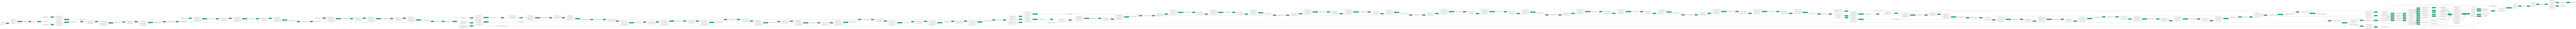

In [5]:
# proto = model.net.Proto()
# proto.ListFields()
from caffe2.python import net_drawer
from IPython import display
graph = net_drawer.GetPydotGraph
(model.net.Proto().op, rankdir="LR")
display.Image(graph.create_png(), width=800)

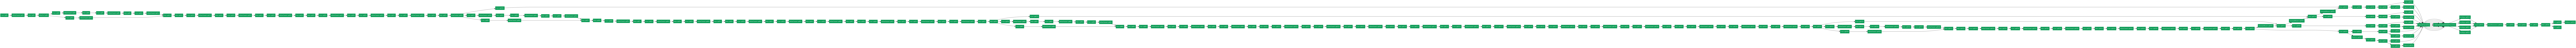

In [6]:
# proto = model.net.Proto()
# proto.ListFields()
from caffe2.python import net_drawer
from IPython import display
graph = net_drawer.GetPydotGraphMinimal(model.net.Proto().op, rankdir="LR",minimal_dependency=True)
display.Image(graph.create_png(), width=800)

In [6]:
png = graph.create_png()
img = display.Image(graph.create_png(), width=800)
graph.write_png('graph.png')

In [10]:
netK = model.net
print(type(netK))

<class 'caffe2.python.core.Net'>


In [7]:
print(model.param_initnnn_net.Proto())

name: "mask_rcnn_init"
op {
  output: "gpu_0/res_conv1_bn_s"
  name: ""
  type: "ConstantFill"
  arg {
    name: "shape"
    ints: 64
  }
  arg {
    name: "value"
    f: 1.0
  }
  device_option {
    device_type: 1
    cuda_gpu_id: 0
  }
}
op {
  output: "gpu_0/res_conv1_bn_b"
  name: ""
  type: "ConstantFill"
  arg {
    name: "shape"
    ints: 64
  }
  arg {
    name: "value"
    f: 0.0
  }
  device_option {
    device_type: 1
    cuda_gpu_id: 0
  }
}
op {
  output: "gpu_0/res2_0_branch2a_bn_s"
  name: ""
  type: "ConstantFill"
  arg {
    name: "shape"
    ints: 64
  }
  arg {
    name: "value"
    f: 1.0
  }
  device_option {
    device_type: 1
    cuda_gpu_id: 0
  }
}
op {
  output: "gpu_0/res2_0_branch2a_bn_b"
  name: ""
  type: "ConstantFill"
  arg {
    name: "shape"
    ints: 64
  }
  arg {
    name: "value"
    f: 0.0
  }
  device_option {
    device_type: 1
    cuda_gpu_id: 0
  }
}
op {
  output: "gpu_0/res2_0_branch2b_bn_s"
  name: ""
  type: "ConstantFill"
  arg {
    nam

In [2]:
for op_ in model.param_init_net.Proto().op:
     for output in op_.output:
            print(output)
#             if output == "fc8_w":
#                   for arg_ in op.arg:
#                           if arg_.name == 'shape':
#                                 arg.ClearField('ints')
#                                 arg_.ints.extend([101, 1024])
#                           elif arg_.name == 'values':
#                                 arg.ClearField('floats')
#                                 arg_.floats.extend(np.random.normal(0, .1, 1024*1000))

gpu_0/res_conv1_bn_s
gpu_0/res_conv1_bn_b
gpu_0/res2_0_branch2a_bn_s
gpu_0/res2_0_branch2a_bn_b
gpu_0/res2_0_branch2b_bn_s
gpu_0/res2_0_branch2b_bn_b
gpu_0/res2_0_branch2c_bn_s
gpu_0/res2_0_branch2c_bn_b
gpu_0/res2_0_branch1_bn_s
gpu_0/res2_0_branch1_bn_b
gpu_0/res2_1_branch2a_bn_s
gpu_0/res2_1_branch2a_bn_b
gpu_0/res2_1_branch2b_bn_s
gpu_0/res2_1_branch2b_bn_b
gpu_0/res2_1_branch2c_bn_s
gpu_0/res2_1_branch2c_bn_b
gpu_0/res2_2_branch2a_bn_s
gpu_0/res2_2_branch2a_bn_b
gpu_0/res2_2_branch2b_bn_s
gpu_0/res2_2_branch2b_bn_b
gpu_0/res2_2_branch2c_bn_s
gpu_0/res2_2_branch2c_bn_b
gpu_0/res3_0_branch2a_bn_s
gpu_0/res3_0_branch2a_bn_b
gpu_0/res3_0_branch2b_bn_s
gpu_0/res3_0_branch2b_bn_b
gpu_0/res3_0_branch2c_bn_s
gpu_0/res3_0_branch2c_bn_b
gpu_0/res3_0_branch1_bn_s
gpu_0/res3_0_branch1_bn_b
gpu_0/res3_1_branch2a_bn_s
gpu_0/res3_1_branch2a_bn_b
gpu_0/res3_1_branch2b_bn_s
gpu_0/res3_1_branch2b_bn_b
gpu_0/res3_1_branch2c_bn_s
gpu_0/res3_1_branch2c_bn_b
gpu_0/res3_2_branch2a_bn_s
gpu_0/res3_2_bran

In [1]:
import sys
sys.path.append('lib/')
# Copyright (c) 2017-present, Facebook, Inc.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
##############################################################################
#
# Based on:
# --------------------------------------------------------
# Fast R-CNN
# Copyright (c) 2015 Microsoft
# Licensed under The MIT License [see LICENSE for details]
# Written by Ross Girshick
# --------------------------------------------------------

"""Inference functionality for most Detectron models."""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

from collections import defaultdict
import cv2
import logging
import numpy as np

from caffe2.python import core
from caffe2.python import workspace
import pycocotools.mask as mask_util

from core.config import cfg
from utils.timer import Timer
import core.test_retinanet as test_retinanet
import modeling.FPN as fpn
import utils.blob as blob_utils
import utils.boxes as box_utils
import utils.image as image_utils
import utils.keypoints as keypoint_utils

logger = logging.getLogger(__name__)


def im_detect_all(model, im, box_proposals, timers=None):
    if timers is None:
        timers = defaultdict(Timer)

    # Handle RetinaNet testing separately for now
    if cfg.RETINANET.RETINANET_ON:
        cls_boxes = test_retinanet.im_detect_bbox(model, im, timers)
        return cls_boxes, None, None

    timers['im_detect_bbox'].tic()
    #print("if enabled: ", cfg.TEST.BBOX_AUG.ENABLED)
    if cfg.TEST.BBOX_AUG.ENABLED:
#         scores, boxes, im_scale = im_detect_bbox(
#             model, im, cfg.TEST.SCALE, cfg.TEST.MAX_SIZE, boxes=box_proposals)
        scores, boxes, im_scale = im_detect_bbox_aug(model, im, box_proposals)
    else:
        scores, boxes, rois, im_scale, fc7_feats, roi_feats, im_info = im_detect_bbox(
            model, im, cfg.TEST.SCALE, cfg.TEST.MAX_SIZE, boxes=box_proposals
        )
    timers['im_detect_bbox'].toc()
    #assert(scores.shape[0] > cfg.TEST.RPN_POST_NMS_TOP_N - 10)
    raw_boxes = boxes
    raw_scores = scores
    timers['misc_bbox'].tic()
    scores, boxes, cls_boxes = box_results_with_nms_and_limit(scores, boxes)
    rpn_size = raw_scores.shape[0]
    ans_boxes = np.zeros((rpn_size,4))
    ans_scores = np.zeros((rpn_size,3))
    for bi in range(rpn_size):
        box_num = bi
        j=np.argmax(raw_scores[box_num,1:])
        j=j+1
        box = raw_boxes[box_num,j * 4:(j + 1) * 4]
        ans_boxes[box_num,:] = box
        ans_scores[box_num,0] = j
        ans_scores[box_num,1] = np.max(raw_scores[box_num,1:])
        ans_scores[box_num,2] = raw_scores[box_num,0] #Bckground score
        
    ans_cls_boxes = {}
    for ci in range(len(cls_boxes)):
        if len(cls_boxes[ci]) > 0:
            ans_cls_boxes[ci] = cls_boxes[ci]
            
        
    timers['misc_bbox'].toc()
    
#     print("returning prematurely!!")
    #return ans_scores, ans_boxes, ans_cls_boxes, im_scale, fc7_feats, im_info


    # score and boxes are from the whole image after score thresholding and nms
    # (they are not separated by class)
    # cls_boxes boxes and scores are separated by class and in the format used
    # for evaluating results
    

    if cfg.MODEL.MASK_ON and boxes.shape[0] > 0:
        timers['im_detect_mask'].tic()
        
        if cfg.TEST.MASK_AUG.ENABLED:
            masks = im_detect_mask_aug(model, im, boxes)
        else:
            masks = im_detect_mask(model, im_scale, boxes)
        timers['im_detect_mask'].toc()

        timers['misc_mask'].tic()
        cls_segms = segm_results(
            cls_boxes, masks, boxes, im.shape[0], im.shape[1]
        )
        timers['misc_mask'].toc()
    else:
        cls_segms = None

    if cfg.MODEL.KEYPOINTS_ON and boxes.shape[0] > 0:
        timers['im_detect_keypoints'].tic()
        if cfg.TEST.KPS_AUG.ENABLED:
            heatmaps = im_detect_keypoints_aug(model, im, boxes)
        else:
            heatmaps = im_detect_keypoints(model, im_scale, boxes)
        timers['im_detect_keypoints'].toc()

        timers['misc_keypoints'].tic()
        cls_keyps = keypoint_results(cls_boxes, heatmaps, boxes)
        timers['misc_keypoints'].toc()
    else:
        cls_keyps = None

    return cls_boxes, cls_segms, cls_keyps


def im_conv_body_only(model, im, target_scale, target_max_size):
    """Runs `model.conv_body_net` on the given image `im`."""
    im_blob, im_scale, _im_info = blob_utils.get_image_blob(
        im, target_scale, target_max_size
    )
    workspace.FeedBlob(core.ScopedName('data'), im_blob)
    workspace.RunNet(model.conv_body_net.Proto().name)
    return im_scale


def im_detect_bbox(model, im, target_scale, target_max_size, boxes=None):
    """Bounding box object detection for an image with given box proposals.
    Arguments:
        model (DetectionModelHelper): the detection model to use
        im (ndarray): color image to test (in BGR order)
        boxes (ndarray): R x 4 array of object proposals in 0-indexed
            [x1, y1, x2, y2] format, or None if using RPN
    Returns:
        scores (ndarray): R x K array of object class scores for K classes
            (K includes background as object category 0)
        boxes (ndarray): R x 4*K array of predicted bounding boxes
        im_scales (list): list of image scales used in the input blob (as
            returned by _get_blobs and for use with im_detect_mask, etc.)
    """
    inputs, im_scale = _get_blobs(im, boxes, target_scale, target_max_size)

    # When mapping from image ROIs to feature map ROIs, there's some aliasing
    # (some distinct image ROIs get mapped to the same feature ROI).
    # Here, we identify duplicate feature ROIs, so we only compute features
    # on the unique subset.
    if cfg.DEDUP_BOXES > 0 and not cfg.MODEL.FASTER_RCNN:
        v = np.array([1, 1e3, 1e6, 1e9, 1e12])
        hashes = np.round(inputs['rois'] * cfg.DEDUP_BOXES).dot(v)
        _, index, inv_index = np.unique(
            hashes, return_index=True, return_inverse=True
        )
        inputs['rois'] = inputs['rois'][index, :]
        boxes = boxes[index, :]

    # Add multi-level rois for FPN
    if cfg.FPN.MULTILEVEL_ROIS and not cfg.MODEL.FASTER_RCNN:
        _add_multilevel_rois_for_test(inputs, 'rois')
    #global_inputs.append(inputs)
    for k, v in inputs.items():
        #print("input: ", core.ScopedName(k))
        workspace.FeedBlob(core.ScopedName(k), v)


    workspace.RunNet(model.net.Proto().name)

    # Read out blobs
    if cfg.MODEL.FASTER_RCNN:
        rois = workspace.FetchBlob(core.ScopedName('rois'))
        # unscale back to raw image space
        boxes = rois[:, 1:5] / im_scale

    # Softmax class probabilities
    #print("cls_prob", core.ScopedName('cls_prob'))
    #global_scores.append(workspace.FetchBlob(core.ScopedName('cls_prob')))
    scores = workspace.FetchBlob(core.ScopedName('cls_prob')).squeeze()

    # In case there is 1 proposal
    scores = scores.reshape([-1, scores.shape[-1]])
    
    if cfg.TEST.BBOX_REG:
        # Apply bounding-box regression deltas
        box_deltas = workspace.FetchBlob(core.ScopedName('bbox_pred')).squeeze()
        # In case there is 1 proposal
        box_deltas = box_deltas.reshape([-1, box_deltas.shape[-1]])
        if cfg.MODEL.CLS_AGNOSTIC_BBOX_REG:
            # Remove predictions for bg class (compat with MSRA code)
            box_deltas = box_deltas[:, -4:]
        pred_boxes = box_utils.bbox_transform(
            boxes, box_deltas, cfg.MODEL.BBOX_REG_WEIGHTS
        )
        
        pred_boxes = box_utils.clip_tiled_boxes(pred_boxes, im.shape)
        
        if cfg.MODEL.CLS_AGNOSTIC_BBOX_REG:
            pred_boxes = np.tile(pred_boxes, (1, scores.shape[1]))
            
    else:
        # Simply repeat the boxes, once for each class
        pred_boxes = np.tile(boxes, (1, scores.shape[1]))
        

    if cfg.DEDUP_BOXES > 0 and not cfg.MODEL.FASTER_RCNN:
        # Map scores and predictions back to the original set of boxes
        scores = scores[inv_index, :]
        pred_boxes = pred_boxes[inv_index, :]
        
    
    fc7_feats = workspace.FetchBlob(core.ScopedName('fc7'))
    roi_feats = workspace.FetchBlob(core.ScopedName('roi_feat'))
    rois = workspace.FetchBlob(core.ScopedName('rois'))
    im_info = workspace.FetchBlob(core.ScopedName('im_info'))
    return scores, pred_boxes, rois, im_scale, fc7_feats, roi_feats, im_info


def im_detect_bbox_aug(model, im, box_proposals=None):
    """Performs bbox detection with test-time augmentations.
    Function signature is the same as for im_detect_bbox.
    """
    assert not cfg.TEST.BBOX_AUG.SCALE_SIZE_DEP, \
        'Size dependent scaling not implemented'
    assert not cfg.TEST.BBOX_AUG.SCORE_HEUR == 'UNION' or \
        cfg.TEST.BBOX_AUG.COORD_HEUR == 'UNION', \
        'Coord heuristic must be union whenever score heuristic is union'
    assert not cfg.TEST.BBOX_AUG.COORD_HEUR == 'UNION' or \
        cfg.TEST.BBOX_AUG.SCORE_HEUR == 'UNION', \
        'Score heuristic must be union whenever coord heuristic is union'
    assert not cfg.MODEL.FASTER_RCNN or \
        cfg.TEST.BBOX_AUG.SCORE_HEUR == 'UNION', \
        'Union heuristic must be used to combine Faster RCNN predictions'

    # Collect detections computed under different transformations
    scores_ts = []
    boxes_ts = []

    def add_preds_t(scores_t, boxes_t):
        scores_ts.append(scores_t)
        boxes_ts.append(boxes_t)

    # Perform detection on the horizontally flipped image
    if cfg.TEST.BBOX_AUG.H_FLIP:
        scores_hf, boxes_hf, _ = im_detect_bbox_hflip(
            model,
            im,
            cfg.TEST.SCALE,
            cfg.TEST.MAX_SIZE,
            box_proposals=box_proposals
        )
        add_preds_t(scores_hf, boxes_hf)

    # Compute detections at different scales
    for scale in cfg.TEST.BBOX_AUG.SCALES:
        max_size = cfg.TEST.BBOX_AUG.MAX_SIZE
        scores_scl, boxes_scl = im_detect_bbox_scale(
            model, im, scale, max_size, box_proposals
        )
        add_preds_t(scores_scl, boxes_scl)

        if cfg.TEST.BBOX_AUG.SCALE_H_FLIP:
            scores_scl_hf, boxes_scl_hf = im_detect_bbox_scale(
                model, im, scale, max_size, box_proposals, hflip=True
            )
            add_preds_t(scores_scl_hf, boxes_scl_hf)

    # Perform detection at different aspect ratios
    for aspect_ratio in cfg.TEST.BBOX_AUG.ASPECT_RATIOS:
        scores_ar, boxes_ar = im_detect_bbox_aspect_ratio(
            model, im, aspect_ratio, box_proposals
        )
        add_preds_t(scores_ar, boxes_ar)

        if cfg.TEST.BBOX_AUG.ASPECT_RATIO_H_FLIP:
            scores_ar_hf, boxes_ar_hf = im_detect_bbox_aspect_ratio(
                model, im, aspect_ratio, box_proposals, hflip=True
            )
            add_preds_t(scores_ar_hf, boxes_ar_hf)

    # Compute detections for the original image (identity transform) last to
    # ensure that the Caffe2 workspace is populated with blobs corresponding
    # to the original image on return (postcondition of im_detect_bbox)
    scores_i, boxes_i, im_scale_i = im_detect_bbox(
        model, im, cfg.TEST.SCALE, cfg.TEST.MAX_SIZE, boxes=box_proposals
    )
    add_preds_t(scores_i, boxes_i)

    # Combine the predicted scores
    if cfg.TEST.BBOX_AUG.SCORE_HEUR == 'ID':
        scores_c = scores_i
    elif cfg.TEST.BBOX_AUG.SCORE_HEUR == 'AVG':
        scores_c = np.mean(scores_ts, axis=0)
    elif cfg.TEST.BBOX_AUG.SCORE_HEUR == 'UNION':
        scores_c = np.vstack(scores_ts)
    else:
        raise NotImplementedError(
            'Score heur {} not supported'.format(cfg.TEST.BBOX_AUG.SCORE_HEUR)
        )

        
    print("heuristic used: ", cfg.TEST.BBOX_AUG.COORD_HEUR)
    # Combine the predicted boxes
    if cfg.TEST.BBOX_AUG.COORD_HEUR == 'ID':
        boxes_c = boxes_i
    elif cfg.TEST.BBOX_AUG.COORD_HEUR == 'AVG':
        boxes_c = np.mean(boxes_ts, axis=0)
    elif cfg.TEST.BBOX_AUG.COORD_HEUR == 'UNION':
        boxes_c = np.vstack(boxes_ts)
    else:
        raise NotImplementedError(
            'Coord heur {} not supported'.format(cfg.TEST.BBOX_AUG.COORD_HEUR)
        )

    return scores_c, boxes_c, im_scale_i


def im_detect_bbox_hflip(
    model, im, target_scale, target_max_size, box_proposals=None
):
    """Performs bbox detection on the horizontally flipped image.
    Function signature is the same as for im_detect_bbox.
    """
    # Compute predictions on the flipped image
    im_hf = im[:, ::-1, :]
    im_width = im.shape[1]

    if not cfg.MODEL.FASTER_RCNN:
        box_proposals_hf = box_utils.flip_boxes(box_proposals, im_width)
    else:
        box_proposals_hf = None

    scores_hf, boxes_hf, im_scale = im_detect_bbox(
        model, im_hf, target_scale, target_max_size, boxes=box_proposals_hf
    )

    # Invert the detections computed on the flipped image
    boxes_inv = box_utils.flip_boxes(boxes_hf, im_width)

    return scores_hf, boxes_inv, im_scale


def im_detect_bbox_scale(
    model, im, target_scale, target_max_size, box_proposals=None, hflip=False
):
    """Computes bbox detections at the given scale.
    Returns predictions in the original image space.
    """
    if hflip:
        scores_scl, boxes_scl, _ = im_detect_bbox_hflip(
            model, im, target_scale, target_max_size, box_proposals=box_proposals
        )
    else:
        scores_scl, boxes_scl, _ = im_detect_bbox(
            model, im, target_scale, target_max_size, boxes=box_proposals
        )
    return scores_scl, boxes_scl


def im_detect_bbox_aspect_ratio(
    model, im, aspect_ratio, box_proposals=None, hflip=False
):
    """Computes bbox detections at the given width-relative aspect ratio.
    Returns predictions in the original image space.
    """
    # Compute predictions on the transformed image
    im_ar = image_utils.aspect_ratio_rel(im, aspect_ratio)

    if not cfg.MODEL.FASTER_RCNN:
        box_proposals_ar = box_utils.aspect_ratio(box_proposals, aspect_ratio)
    else:
        box_proposals_ar = None

    if hflip:
        scores_ar, boxes_ar, _ = im_detect_bbox_hflip(
            model,
            im_ar,
            cfg.TEST.SCALE,
            cfg.TEST.MAX_SIZE,
            box_proposals=box_proposals_ar
        )
    else:
        scores_ar, boxes_ar, _ = im_detect_bbox(
            model,
            im_ar,
            cfg.TEST.SCALE,
            cfg.TEST.MAX_SIZE,
            boxes=box_proposals_ar
        )

    # Invert the detected boxes
    boxes_inv = box_utils.aspect_ratio(boxes_ar, 1.0 / aspect_ratio)

    return scores_ar, boxes_inv


def im_detect_mask(model, im_scale, boxes):
    """Infer instance segmentation masks. This function must be called after
    im_detect_bbox as it assumes that the Caffe2 workspace is already populated
    with the necessary blobs.
    Arguments:
        model (DetectionModelHelper): the detection model to use
        im_scales (list): image blob scales as returned by im_detect_bbox
        boxes (ndarray): R x 4 array of bounding box detections (e.g., as
            returned by im_detect_bbox)
    Returns:
        pred_masks (ndarray): R x K x M x M array of class specific soft masks
            output by the network (must be processed by segm_results to convert
            into hard masks in the original image coordinate space)
    """
    M = cfg.MRCNN.RESOLUTION
    if boxes.shape[0] == 0:
        pred_masks = np.zeros((0, M, M), np.float32)
        return pred_masks

    inputs = {'mask_rois': _get_rois_blob(boxes, im_scale)}
    # Add multi-level rois for FPN
    if cfg.FPN.MULTILEVEL_ROIS:
        _add_multilevel_rois_for_test(inputs, 'mask_rois')

    for k, v in inputs.items():
        workspace.FeedBlob(core.ScopedName(k), v)
    workspace.RunNet(model.mask_net.Proto().name)

    # Fetch masks
    pred_masks = workspace.FetchBlob(
        core.ScopedName('mask_fcn_probs')
    ).squeeze()

    if cfg.MRCNN.CLS_SPECIFIC_MASK:
        pred_masks = pred_masks.reshape([-1, cfg.MODEL.NUM_CLASSES, M, M])
    else:
        pred_masks = pred_masks.reshape([-1, 1, M, M])

    return pred_masks


def im_detect_mask_aug(model, im, boxes):
    """Performs mask detection with test-time augmentations.
    Arguments:
        model (DetectionModelHelper): the detection model to use
        im (ndarray): BGR image to test
        boxes (ndarray): R x 4 array of bounding boxes
    Returns:
        masks (ndarray): R x K x M x M array of class specific soft masks
    """
    assert not cfg.TEST.MASK_AUG.SCALE_SIZE_DEP, \
        'Size dependent scaling not implemented'

    # Collect masks computed under different transformations
    masks_ts = []

    # Compute masks for the original image (identity transform)
    im_scale_i = im_conv_body_only(model, im, cfg.TEST.SCALE, cfg.TEST.MAX_SIZE)
    masks_i = im_detect_mask(model, im_scale_i, boxes)
    masks_ts.append(masks_i)

    # Perform mask detection on the horizontally flipped image
    if cfg.TEST.MASK_AUG.H_FLIP:
        masks_hf = im_detect_mask_hflip(
            model, im, cfg.TEST.SCALE, cfg.TEST.MAX_SIZE, boxes
        )
        masks_ts.append(masks_hf)

    # Compute detections at different scales
    for scale in cfg.TEST.MASK_AUG.SCALES:
        max_size = cfg.TEST.MASK_AUG.MAX_SIZE
        masks_scl = im_detect_mask_scale(model, im, scale, max_size, boxes)
        masks_ts.append(masks_scl)

        if cfg.TEST.MASK_AUG.SCALE_H_FLIP:
            masks_scl_hf = im_detect_mask_scale(
                model, im, scale, max_size, boxes, hflip=True
            )
            masks_ts.append(masks_scl_hf)

    # Compute masks at different aspect ratios
    for aspect_ratio in cfg.TEST.MASK_AUG.ASPECT_RATIOS:
        masks_ar = im_detect_mask_aspect_ratio(model, im, aspect_ratio, boxes)
        masks_ts.append(masks_ar)

        if cfg.TEST.MASK_AUG.ASPECT_RATIO_H_FLIP:
            masks_ar_hf = im_detect_mask_aspect_ratio(
                model, im, aspect_ratio, boxes, hflip=True
            )
            masks_ts.append(masks_ar_hf)

    # Combine the predicted soft masks
    if cfg.TEST.MASK_AUG.HEUR == 'SOFT_AVG':
        masks_c = np.mean(masks_ts, axis=0)
    elif cfg.TEST.MASK_AUG.HEUR == 'SOFT_MAX':
        masks_c = np.amax(masks_ts, axis=0)
    elif cfg.TEST.MASK_AUG.HEUR == 'LOGIT_AVG':

        def logit(y):
            return -1.0 * np.log((1.0 - y) / np.maximum(y, 1e-20))

        logit_masks = [logit(y) for y in masks_ts]
        logit_masks = np.mean(logit_masks, axis=0)
        masks_c = 1.0 / (1.0 + np.exp(-logit_masks))
    else:
        raise NotImplementedError(
            'Heuristic {} not supported'.format(cfg.TEST.MASK_AUG.HEUR)
        )

    return masks_c


def im_detect_mask_hflip(model, im, target_scale, target_max_size, boxes):
    """Performs mask detection on the horizontally flipped image.
    Function signature is the same as for im_detect_mask_aug.
    """
    # Compute the masks for the flipped image
    im_hf = im[:, ::-1, :]
    boxes_hf = box_utils.flip_boxes(boxes, im.shape[1])

    im_scale = im_conv_body_only(model, im_hf, target_scale, target_max_size)
    masks_hf = im_detect_mask(model, im_scale, boxes_hf)

    # Invert the predicted soft masks
    masks_inv = masks_hf[:, :, :, ::-1]

    return masks_inv


def im_detect_mask_scale(
    model, im, target_scale, target_max_size, boxes, hflip=False
):
    """Computes masks at the given scale."""
    if hflip:
        masks_scl = im_detect_mask_hflip(
            model, im, target_scale, target_max_size, boxes
        )
    else:
        im_scale = im_conv_body_only(model, im, target_scale, target_max_size)
        masks_scl = im_detect_mask(model, im_scale, boxes)
    return masks_scl


def im_detect_mask_aspect_ratio(model, im, aspect_ratio, boxes, hflip=False):
    """Computes mask detections at the given width-relative aspect ratio."""

    # Perform mask detection on the transformed image
    im_ar = image_utils.aspect_ratio_rel(im, aspect_ratio)
    boxes_ar = box_utils.aspect_ratio(boxes, aspect_ratio)

    if hflip:
        masks_ar = im_detect_mask_hflip(
            model, im_ar, cfg.TEST.SCALE, cfg.TEST.MAX_SIZE, boxes_ar
        )
    else:
        im_scale = im_conv_body_only(
            model, im_ar, cfg.TEST.SCALE, cfg.TEST.MAX_SIZE
        )
        masks_ar = im_detect_mask(model, im_scale, boxes_ar)

    return masks_ar


def im_detect_keypoints(model, im_scale, boxes):
    """Infer instance keypoint poses. This function must be called after
    im_detect_bbox as it assumes that the Caffe2 workspace is already populated
    with the necessary blobs.
    Arguments:
        model (DetectionModelHelper): the detection model to use
        im_scales (list): image blob scales as returned by im_detect_bbox
        boxes (ndarray): R x 4 array of bounding box detections (e.g., as
            returned by im_detect_bbox)
    Returns:
        pred_heatmaps (ndarray): R x J x M x M array of keypoint location
            logits (softmax inputs) for each of the J keypoint types output
            by the network (must be processed by keypoint_results to convert
            into point predictions in the original image coordinate space)
    """
    M = cfg.KRCNN.HEATMAP_SIZE
    if boxes.shape[0] == 0:
        pred_heatmaps = np.zeros((0, cfg.KRCNN.NUM_KEYPOINTS, M, M), np.float32)
        return pred_heatmaps

    inputs = {'keypoint_rois': _get_rois_blob(boxes, im_scale)}

    # Add multi-level rois for FPN
    if cfg.FPN.MULTILEVEL_ROIS:
        _add_multilevel_rois_for_test(inputs, 'keypoint_rois')

    for k, v in inputs.items():
        workspace.FeedBlob(core.ScopedName(k), v)
    workspace.RunNet(model.keypoint_net.Proto().name)

    pred_heatmaps = workspace.FetchBlob(core.ScopedName('kps_score')).squeeze()

    # In case of 1
    if pred_heatmaps.ndim == 3:
        pred_heatmaps = np.expand_dims(pred_heatmaps, axis=0)

    return pred_heatmaps


def im_detect_keypoints_aug(model, im, boxes):
    """Computes keypoint predictions with test-time augmentations.
    Arguments:
        model (DetectionModelHelper): the detection model to use
        im (ndarray): BGR image to test
        boxes (ndarray): R x 4 array of bounding boxes
    Returns:
        heatmaps (ndarray): R x J x M x M array of keypoint location logits
    """

    # Collect heatmaps predicted under different transformations
    heatmaps_ts = []
    # Tag predictions computed under downscaling and upscaling transformations
    ds_ts = []
    us_ts = []

    def add_heatmaps_t(heatmaps_t, ds_t=False, us_t=False):
        heatmaps_ts.append(heatmaps_t)
        ds_ts.append(ds_t)
        us_ts.append(us_t)

    # Compute the heatmaps for the original image (identity transform)
    im_scale = im_conv_body_only(model, im, cfg.TEST.SCALE, cfg.TEST.MAX_SIZE)
    heatmaps_i = im_detect_keypoints(model, im_scale, boxes)
    add_heatmaps_t(heatmaps_i)

    # Perform keypoints detection on the horizontally flipped image
    if cfg.TEST.KPS_AUG.H_FLIP:
        heatmaps_hf = im_detect_keypoints_hflip(
            model, im, cfg.TEST.SCALE, cfg.TEST.MAX_SIZE, boxes
        )
        add_heatmaps_t(heatmaps_hf)

    # Compute detections at different scales
    for scale in cfg.TEST.KPS_AUG.SCALES:
        ds_scl = scale < cfg.TEST.SCALE
        us_scl = scale > cfg.TEST.SCALE
        heatmaps_scl = im_detect_keypoints_scale(
            model, im, scale, cfg.TEST.KPS_AUG.MAX_SIZE, boxes
        )
        add_heatmaps_t(heatmaps_scl, ds_scl, us_scl)

        if cfg.TEST.KPS_AUG.SCALE_H_FLIP:
            heatmaps_scl_hf = im_detect_keypoints_scale(
                model, im, scale, cfg.TEST.KPS_AUG.MAX_SIZE, boxes, hflip=True
            )
            add_heatmaps_t(heatmaps_scl_hf, ds_scl, us_scl)

    # Compute keypoints at different aspect ratios
    for aspect_ratio in cfg.TEST.KPS_AUG.ASPECT_RATIOS:
        heatmaps_ar = im_detect_keypoints_aspect_ratio(
            model, im, aspect_ratio, boxes
        )
        add_heatmaps_t(heatmaps_ar)

        if cfg.TEST.KPS_AUG.ASPECT_RATIO_H_FLIP:
            heatmaps_ar_hf = im_detect_keypoints_aspect_ratio(
                model, im, aspect_ratio, boxes, hflip=True
            )
            add_heatmaps_t(heatmaps_ar_hf)

    # Select the heuristic function for combining the heatmaps
    if cfg.TEST.KPS_AUG.HEUR == 'HM_AVG':
        np_f = np.mean
    elif cfg.TEST.KPS_AUG.HEUR == 'HM_MAX':
        np_f = np.amax
    else:
        raise NotImplementedError(
            'Heuristic {} not supported'.format(cfg.TEST.KPS_AUG.HEUR)
        )

    def heur_f(hms_ts):
        return np_f(hms_ts, axis=0)

    # Combine the heatmaps
    if cfg.TEST.KPS_AUG.SCALE_SIZE_DEP:
        heatmaps_c = combine_heatmaps_size_dep(
            heatmaps_ts, ds_ts, us_ts, boxes, heur_f
        )
    else:
        heatmaps_c = heur_f(heatmaps_ts)

    return heatmaps_c


def im_detect_keypoints_hflip(model, im, target_scale, target_max_size, boxes):
    """Computes keypoint predictions on the horizontally flipped image.
    Function signature is the same as for im_detect_keypoints_aug.
    """
    # Compute keypoints for the flipped image
    im_hf = im[:, ::-1, :]
    boxes_hf = box_utils.flip_boxes(boxes, im.shape[1])

    im_scale = im_conv_body_only(model, im_hf, target_scale, target_max_size)
    heatmaps_hf = im_detect_keypoints(model, im_scale, boxes_hf)

    # Invert the predicted keypoints
    heatmaps_inv = keypoint_utils.flip_heatmaps(heatmaps_hf)

    return heatmaps_inv


def im_detect_keypoints_scale(
    model, im, target_scale, target_max_size, boxes, hflip=False
):
    """Computes keypoint predictions at the given scale."""
    if hflip:
        heatmaps_scl = im_detect_keypoints_hflip(
            model, im, target_scale, target_max_size, boxes
        )
    else:
        im_scale = im_conv_body_only(model, im, target_scale, target_max_size)
        heatmaps_scl = im_detect_keypoints(model, im_scale, boxes)
    return heatmaps_scl


def im_detect_keypoints_aspect_ratio(
    model, im, aspect_ratio, boxes, hflip=False
):
    """Detects keypoints at the given width-relative aspect ratio."""

    # Perform keypoint detectionon the transformed image
    im_ar = image_utils.aspect_ratio_rel(im, aspect_ratio)
    boxes_ar = box_utils.aspect_ratio(boxes, aspect_ratio)

    if hflip:
        heatmaps_ar = im_detect_keypoints_hflip(
            model, im_ar, cfg.TEST.SCALE, cfg.TEST.MAX_SIZE, boxes_ar
        )
    else:
        im_scale = im_conv_body_only(
            model, im_ar, cfg.TEST.SCALE, cfg.TEST.MAX_SIZE
        )
        heatmaps_ar = im_detect_keypoints(model, im_scale, boxes_ar)

    return heatmaps_ar


def combine_heatmaps_size_dep(hms_ts, ds_ts, us_ts, boxes, heur_f):
    """Combines heatmaps while taking object sizes into account."""
    assert len(hms_ts) == len(ds_ts) and len(ds_ts) == len(us_ts), \
        'All sets of hms must be tagged with downscaling and upscaling flags'

    # Classify objects into small+medium and large based on their box areas
    areas = box_utils.boxes_area(boxes)
    sm_objs = areas < cfg.TEST.KPS_AUG.AREA_TH
    l_objs = areas >= cfg.TEST.KPS_AUG.AREA_TH

    # Combine heatmaps computed under different transformations for each object
    hms_c = np.zeros_like(hms_ts[0])

    for i in range(hms_c.shape[0]):
        hms_to_combine = []
        for hms_t, ds_t, us_t in zip(hms_ts, ds_ts, us_ts):
            # Discard downscaling predictions for small and medium objects
            if sm_objs[i] and ds_t:
                continue
            # Discard upscaling predictions for large objects
            if l_objs[i] and us_t:
                continue
            hms_to_combine.append(hms_t[i])
        hms_c[i] = heur_f(hms_to_combine)

    return hms_c


def box_results_with_nms_and_limit(scores, boxes):
    """Returns bounding-box detection results by thresholding on scores and
    applying non-maximum suppression (NMS).
    `boxes` has shape (#detections, 4 * #classes), where each row represents
    a list of predicted bounding boxes for each of the object classes in the
    dataset (including the background class). The detections in each row
    originate from the same object proposal.
    `scores` has shape (#detection, #classes), where each row represents a list
    of object detection confidence scores for each of the object classes in the
    dataset (including the background class). `scores[i, j]`` corresponds to the
    box at `boxes[i, j * 4:(j + 1) * 4]`.
    """
    num_classes = cfg.MODEL.NUM_CLASSES
    cls_boxes = [[] for _ in range(num_classes)]
    # Apply threshold on detection probabilities and apply NMS
    # Skip j = 0, because it's the background class
    for j in range(1, num_classes):
        inds = np.where(scores[:, j] > cfg.TEST.SCORE_THRESH)[0]
        scores_j = scores[inds, j]
        boxes_j = boxes[inds, j * 4:(j + 1) * 4]
        dets_j = np.hstack((boxes_j, scores_j[:, np.newaxis])).astype(
            np.float32, copy=False
        )
        if cfg.TEST.SOFT_NMS.ENABLED:
            nms_dets, _ = box_utils.soft_nms(
                dets_j,
                sigma=cfg.TEST.SOFT_NMS.SIGMA,
                overlap_thresh=cfg.TEST.NMS,
                score_thresh=0.0001,
                method=cfg.TEST.SOFT_NMS.METHOD
            )
        else:
            keep = box_utils.nms(dets_j, cfg.TEST.NMS)
            nms_dets = dets_j[keep, :]
        # Refine the post-NMS boxes using bounding-box voting
        if cfg.TEST.BBOX_VOTE.ENABLED:
            nms_dets = box_utils.box_voting(
                nms_dets,
                dets_j,
                cfg.TEST.BBOX_VOTE.VOTE_TH,
                scoring_method=cfg.TEST.BBOX_VOTE.SCORING_METHOD
            )
        cls_boxes[j] = nms_dets

    # Limit to max_per_image detections **over all classes**
    if cfg.TEST.DETECTIONS_PER_IM > 0:
        image_scores = np.hstack(
            [cls_boxes[j][:, -1] for j in range(1, num_classes)]
        )
        if len(image_scores) > cfg.TEST.DETECTIONS_PER_IM:
            image_thresh = np.sort(image_scores)[-cfg.TEST.DETECTIONS_PER_IM]
            for j in range(1, num_classes):
                keep = np.where(cls_boxes[j][:, -1] >= image_thresh)[0]
                cls_boxes[j] = cls_boxes[j][keep, :]

    im_results = np.vstack([cls_boxes[j] for j in range(1, num_classes)])
    boxes = im_results[:, :-1]
    scores = im_results[:, -1]
    return scores, boxes, cls_boxes


def segm_results(cls_boxes, masks, ref_boxes, im_h, im_w):
    num_classes = cfg.MODEL.NUM_CLASSES
    cls_segms = [[] for _ in range(num_classes)]
    mask_ind = 0
    # To work around an issue with cv2.resize (it seems to automatically pad
    # with repeated border values), we manually zero-pad the masks by 1 pixel
    # prior to resizing back to the original image resolution. This prevents
    # "top hat" artifacts. We therefore need to expand the reference boxes by an
    # appropriate factor.
    M = cfg.MRCNN.RESOLUTION
    scale = (M + 2.0) / M
    ref_boxes = box_utils.expand_boxes(ref_boxes, scale)
    ref_boxes = ref_boxes.astype(np.int32)
    padded_mask = np.zeros((M + 2, M + 2), dtype=np.float32)

    # skip j = 0, because it's the background class
    for j in range(1, num_classes):
        segms = []
        for _ in range(cls_boxes[j].shape[0]):
            if cfg.MRCNN.CLS_SPECIFIC_MASK:
                padded_mask[1:-1, 1:-1] = masks[mask_ind, j, :, :]
            else:
                padded_mask[1:-1, 1:-1] = masks[mask_ind, 0, :, :]

            ref_box = ref_boxes[mask_ind, :]
            w = ref_box[2] - ref_box[0] + 1
            h = ref_box[3] - ref_box[1] + 1
            w = np.maximum(w, 1)
            h = np.maximum(h, 1)

            mask = cv2.resize(padded_mask, (w, h))
            mask = np.array(mask > cfg.MRCNN.THRESH_BINARIZE, dtype=np.uint8)
            im_mask = np.zeros((im_h, im_w), dtype=np.uint8)

            x_0 = max(ref_box[0], 0)
            x_1 = min(ref_box[2] + 1, im_w)
            y_0 = max(ref_box[1], 0)
            y_1 = min(ref_box[3] + 1, im_h)

            im_mask[y_0:y_1, x_0:x_1] = mask[
                (y_0 - ref_box[1]):(y_1 - ref_box[1]),
                (x_0 - ref_box[0]):(x_1 - ref_box[0])
            ]

            # Get RLE encoding used by the COCO evaluation API
            rle = mask_util.encode(
                np.array(im_mask[:, :, np.newaxis], order='F')
            )[0]
            segms.append(rle)

            mask_ind += 1

        cls_segms[j] = segms

    assert mask_ind == masks.shape[0]
    return cls_segms


def keypoint_results(cls_boxes, pred_heatmaps, ref_boxes):
    num_classes = cfg.MODEL.NUM_CLASSES
    cls_keyps = [[] for _ in range(num_classes)]
    person_idx = keypoint_utils.get_person_class_index()
    xy_preds = keypoint_utils.heatmaps_to_keypoints(pred_heatmaps, ref_boxes)

    # NMS OKS
    if cfg.KRCNN.NMS_OKS:
        keep = keypoint_utils.nms_oks(xy_preds, ref_boxes, 0.3)
        xy_preds = xy_preds[keep, :, :]
        ref_boxes = ref_boxes[keep, :]
        pred_heatmaps = pred_heatmaps[keep, :, :, :]
        cls_boxes[person_idx] = cls_boxes[person_idx][keep, :]

    kps = [xy_preds[i] for i in range(xy_preds.shape[0])]
    cls_keyps[person_idx] = kps
    return cls_keyps


def _get_rois_blob(im_rois, im_scale):
    """Converts RoIs into network inputs.
    Arguments:
        im_rois (ndarray): R x 4 matrix of RoIs in original image coordinates
        im_scale_factors (list): scale factors as returned by _get_image_blob
    Returns:
        blob (ndarray): R x 5 matrix of RoIs in the image pyramid with columns
            [level, x1, y1, x2, y2]
    """
    rois, levels = _project_im_rois(im_rois, im_scale)
    rois_blob = np.hstack((levels, rois))
    return rois_blob.astype(np.float32, copy=False)


def _project_im_rois(im_rois, scales):
    """Project image RoIs into the image pyramid built by _get_image_blob.
    Arguments:
        im_rois (ndarray): R x 4 matrix of RoIs in original image coordinates
        scales (list): scale factors as returned by _get_image_blob
    Returns:
        rois (ndarray): R x 4 matrix of projected RoI coordinates
        levels (ndarray): image pyramid levels used by each projected RoI
    """
    rois = im_rois.astype(np.float, copy=False) * scales
    levels = np.zeros((im_rois.shape[0], 1), dtype=np.int)
    return rois, levels


def _add_multilevel_rois_for_test(blobs, name):
    """Distributes a set of RoIs across FPN pyramid levels by creating new level
    specific RoI blobs.
    Arguments:
        blobs (dict): dictionary of blobs
        name (str): a key in 'blobs' identifying the source RoI blob
    Returns:
        [by ref] blobs (dict): new keys named by `name + 'fpn' + level`
            are added to dict each with a value that's an R_level x 5 ndarray of
            RoIs (see _get_rois_blob for format)
    """
    lvl_min = cfg.FPN.ROI_MIN_LEVEL
    lvl_max = cfg.FPN.ROI_MAX_LEVEL
    lvls = fpn.map_rois_to_fpn_levels(blobs[name][:, 1:5], lvl_min, lvl_max)
    fpn.add_multilevel_roi_blobs(
        blobs, name, blobs[name], lvls, lvl_min, lvl_max
    )


def _get_blobs(im, rois, target_scale, target_max_size):
    """Convert an image and RoIs within that image into network inputs."""
    blobs = {}
    blobs['data'], im_scale, blobs['im_info'] = \
        blob_utils.get_image_blob(im, target_scale, target_max_size)
    if rois is not None:
        blobs['rois'] = _get_rois_blob(rois, im_scale)
    return blobs, im_scale